# Adaptive Line Enhancer for speech denoising

This notebook does the following:
1. Load speech and noise files, create additive mixture
2. Choose a learning parameter mu, delta time units which is the range of correlation that is used for statistical prediction

In [131]:
import numpy as np
import matplotlib.pylab as plt

import padasip as pa

In [436]:
""" Generate the noisy speech signal from a clean speech signal by adding noise"""
import librosa 

speech_file = "wav/input/female.wav"
noise_file = "wav/input/noise_white.wav"

s, fs = librosa.load(speech_file, sr=16000)
s = np.concatenate((s, s))

n, fs_noise = librosa.load(noise_file, sr=16000)

noise_gain = 0.7
n = noise_gain * n[:len(s)]

x = s + n

# Compute the Input SNR for signal s to noise n
x_snr = 10*np.log10(np.sum(s**2)/np.sum(n**2))
print("SNR: {:.2f}dB".format(x_snr))

SNR: 18.30dB


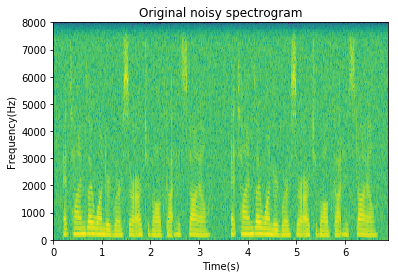

In [437]:
plt.specgram(x, Fs=fs);
plt.title('Original noisy spectrogram');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');

512


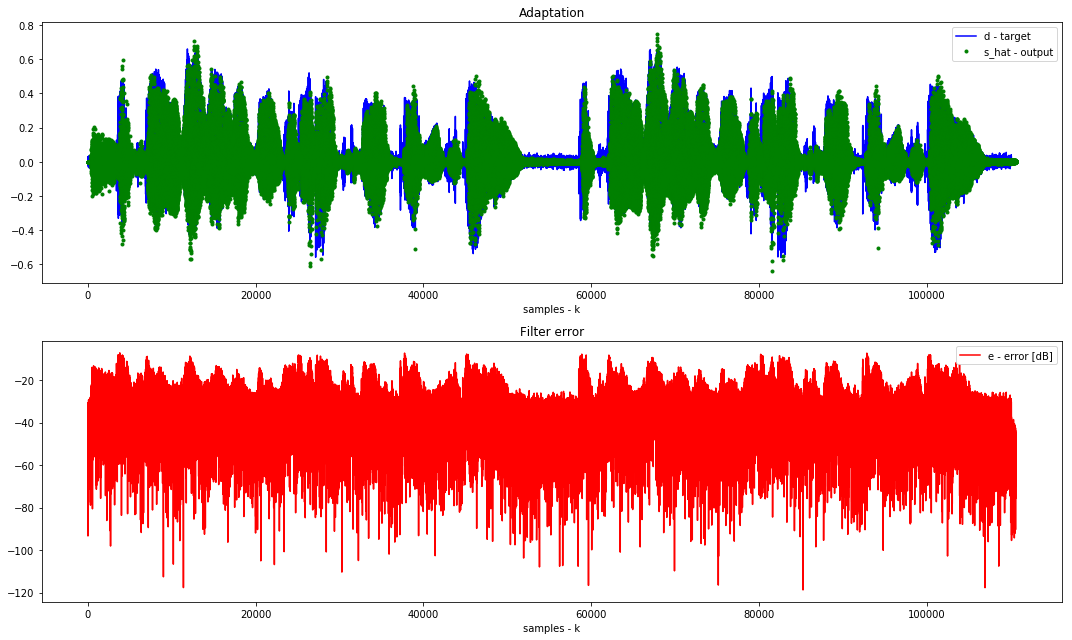

In [525]:
# creation of data
N = 128
delta_ms = 32
delta = int(fs*delta_ms/1000)
print(delta)
x_ale = pa.input_from_history(np.concatenate((np.zeros(delta,), x)), N)

# Create desired signal
d_ale = np.zeros((x_ale.shape[0],))
for i in range(delta, x_ale.shape[0]):
    d_ale[i-delta] = x_ale[i][0]

# ale
f = pa.filters.FilterNLMS(n=N, mu=1, w="random")
s_hat, n_hat, weights = f.run(d_ale, x_ale)

# anc
# f2 = pa.filters.FilterNLMS(n=N, mu=0.1, w="random")
# x_anc = pa.input_from_history(n_hat, N)
# n_hat, s_hat, weights = f2.run(s_hat[:x_anc.shape[0]], x_anc)

# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(d,"b", label="d - target")
plt.plot(s_hat,"g.", label="s_hat - output");plt.legend()
plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(n_hat**2),"r", label="e - error [dB]");plt.legend()
plt.tight_layout()
plt.show()

In [526]:
# Create s_hat2 which is the original speech signal passed through the delay and ALE to see how much distortion there is to the original speech
s_hat2 = []
s_ale = pa.input_from_history(np.concatenate((np.zeros(delta,), s)), N)
for i in range(weights.shape[0]):
    val = np.dot(weights[i], s_ale[i])
    s_hat2.append(val)
    
n_hat2 = []
n_ale = pa.input_from_history(np.concatenate((np.zeros(delta,), n)), N)
for i in range(weights.shape[0]):
    val = np.dot(weights[i], n_ale[i])
    n_hat2.append(val)    

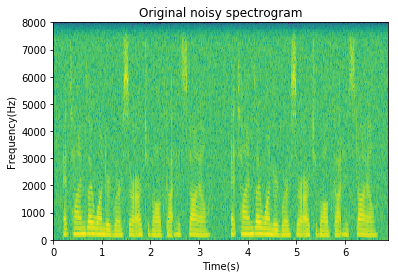

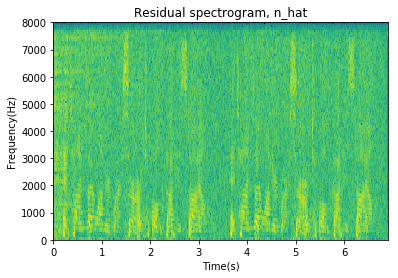

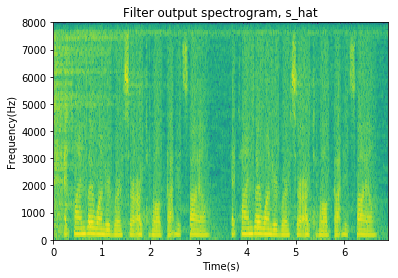

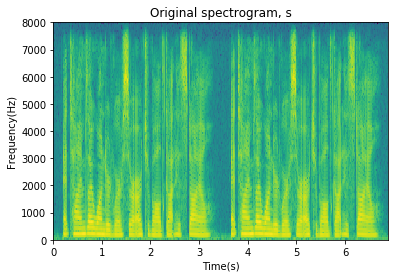

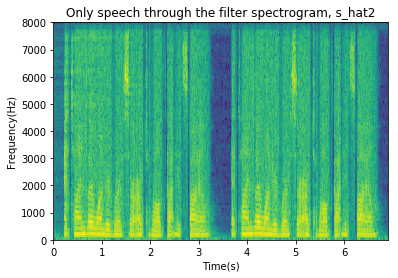

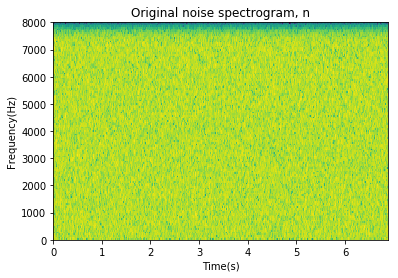

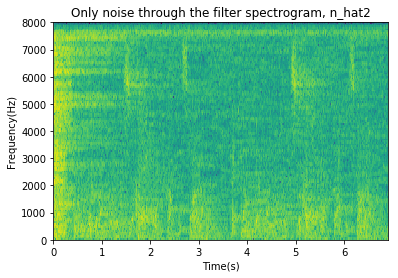

In [527]:
plt.specgram(x, Fs=fs);
plt.title('Original noisy spectrogram');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(n_hat, Fs=fs);
plt.title('Residual spectrogram, n_hat');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(s_hat, Fs=fs);
plt.title('Filter output spectrogram, s_hat');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(s, Fs=fs);
plt.title('Original spectrogram, s');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(s_hat2, Fs=fs);
plt.title('Only speech through the filter spectrogram, s_hat2');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(n, Fs=fs);
plt.title('Original noise spectrogram, n');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');
plt.figure();
plt.specgram(n_hat2, Fs=fs);
plt.title('Only noise through the filter spectrogram, n_hat2');
plt.xlabel('Time(s)');
plt.ylabel('Frequency(Hz)');

In [528]:
from IPython.display import Audio

Audio(data=n_hat, rate=fs)

In [529]:
Audio(data=s_hat, rate=fs)

In [530]:
Audio(data=s_hat2, rate=fs)

In [531]:
Audio(data=s, rate=fs)

In [532]:
Audio(data=x, rate=fs)

# Metrics

1. Input SNR
2. Output SNR
3. Input Distortion

In [483]:
# Input SNR

input_snr = 10*np.log10(np.sum(s**2)/np.sum(n**2))
print("Input SNR: {} dB".format(input_snr))

Input SNR: 18.30080270767212 dB


In [484]:
# Output SNR
# Use the last 10% of the audio clip
samp_idx = int(0.9*len(s_hat));
output_snr = np.sum(s_hat[samp_idx:]**2)/np.sum(n_hat[samp_idx:]**2)
print("Output SNR: {} dB".format(output_snr))

Output SNR: 1.3228023677497744 dB


In [377]:
s_hat.shape, x.shape

((132193,), (132320,))

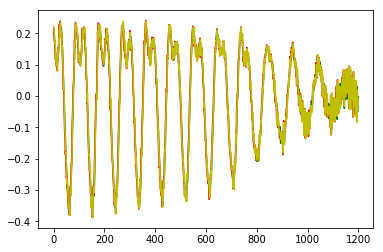

In [378]:
plt.plot(s[-10200:-9000], 'g')
plt.plot(s_hat[-10200-delta+N:-9000-delta+N], 'r')
plt.plot(x[-10200:-9000], 'y')

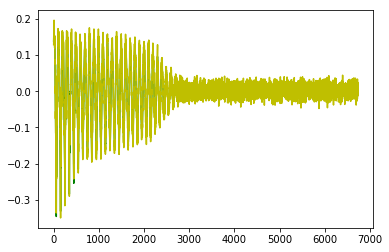

In [379]:
samp_idx = int(0.95*len(s_hat));
plt.plot(s[samp_idx:], 'g')
# plt.plot(s_hat[samp_idx-delta+N:samp_idx-delta+N], 'r')
plt.plot(x[samp_idx:], 'y')

In [452]:
10*np.log10(np.sum((s-s_hat[len(s_hat)-len(s):])**2)/len(s_hat))

ValueError: operands could not be broadcast together with shapes (110242,) (109730,) 

In [455]:
len(s_hat), len(s)

(110627, 110242)

In [448]:
10*np.log10(np.sum((n)**2)/len(s_hat))

-37.05548540205791